In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="tqdm")

import logging
logging.getLogger('rpy2').setLevel(logging.WARNING)

%load_ext autoreload
%autoreload 2
# from ipython import autoreload
import numpy as np
import itertools
import yaml
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import causallearn
from causallearn.graph.Edge import Edge
from causallearn.graph.Endpoint import Endpoint
from causallearn.search.ConstraintBased.FCI import fci
import random

from clustercausal.algorithms.ClusterPC import ClusterPC
from clustercausal.algorithms.ClusterFCI import ClusterFCI
from clustercausal.clusterdag.ClusterDAG import ClusterDAG
from clustercausal.experiments.Evaluator import Evaluator
# from clustercausal.experiments.ExperimentRunner import ExperimentRunner
from clustercausal.experiments.ExperimentRunnervsFCITiers import (
    ExperimentRunner,
)
from clustercausal.utils.Utils import *
from clustercausal.experiments.Utils import load_experiment_folder
from clustercausal.utils.Utils import *
from clustercausal.experiments.Simulator import Simulator
from clustercausal.algorithms.FCITiers import fci_tiers

c:\Users\ga87val\00_PhD\Paper Development\ClusterDAGs_causal_discovery\clustercausal\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [2]:
# # cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2'], 'C2' : ['X3', 'X4'], 'C3' : ['X5', 'X6']}, \
# #                          cluster_edges = [('C1', 'C2'), ('C2', 'C3')], \
# #                          cluster_bidirected_edges=[('C2', 'C3')])
# cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2'], 'C2' : ['X3', 'X4'], 'C3' : ['X5', 'X6'], 'C4' : ['X7', 'X8']}, \
#                          cluster_edges = [('C1', 'C2'), ('C2', 'C3'), ('C1', 'C4')], \
#                          cluster_bidirected_edges=[('C2', 'C3'), ('C3', 'C4')])
# # cluster_dag.cluster_graph.draw_pydot_graph()

In [3]:
simulation = Simulator(n_nodes = 20, n_edges = 20, n_clusters = 4, seed = 232)
cluster_dag = simulation.run_with_latents()

INFO: Finished synthetic dataset


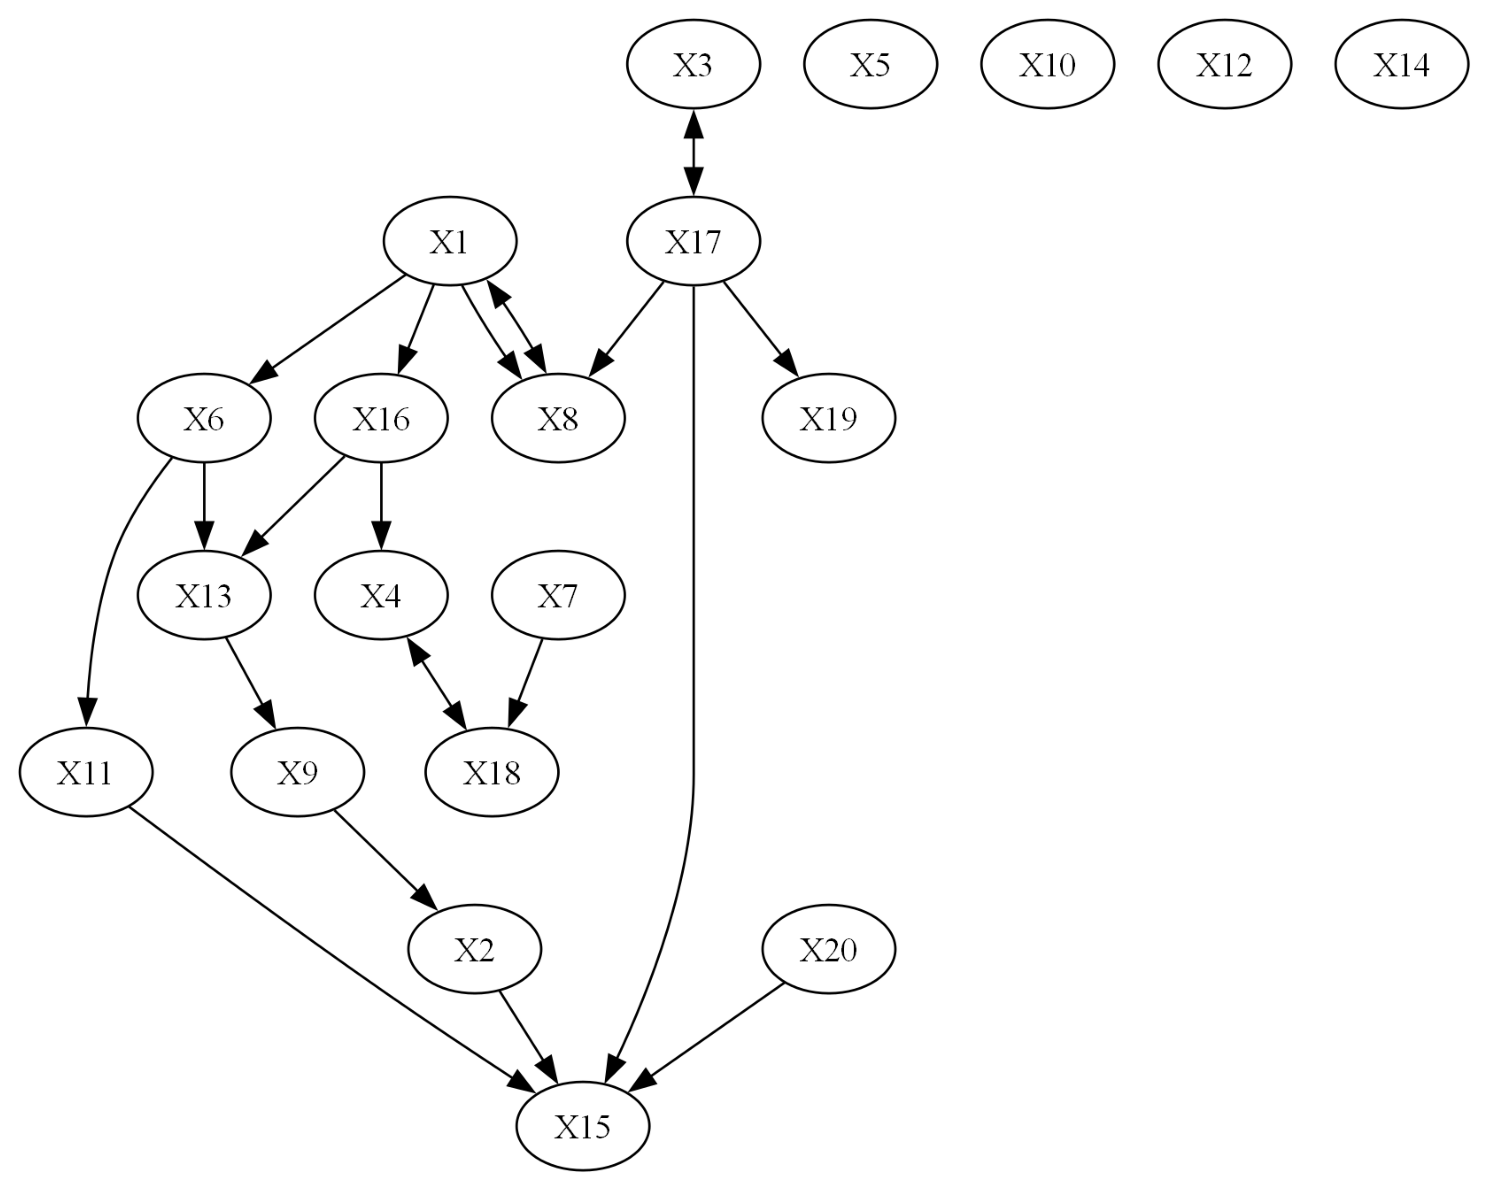

In [4]:
cluster_dag.true_dag.draw_pydot_graph()

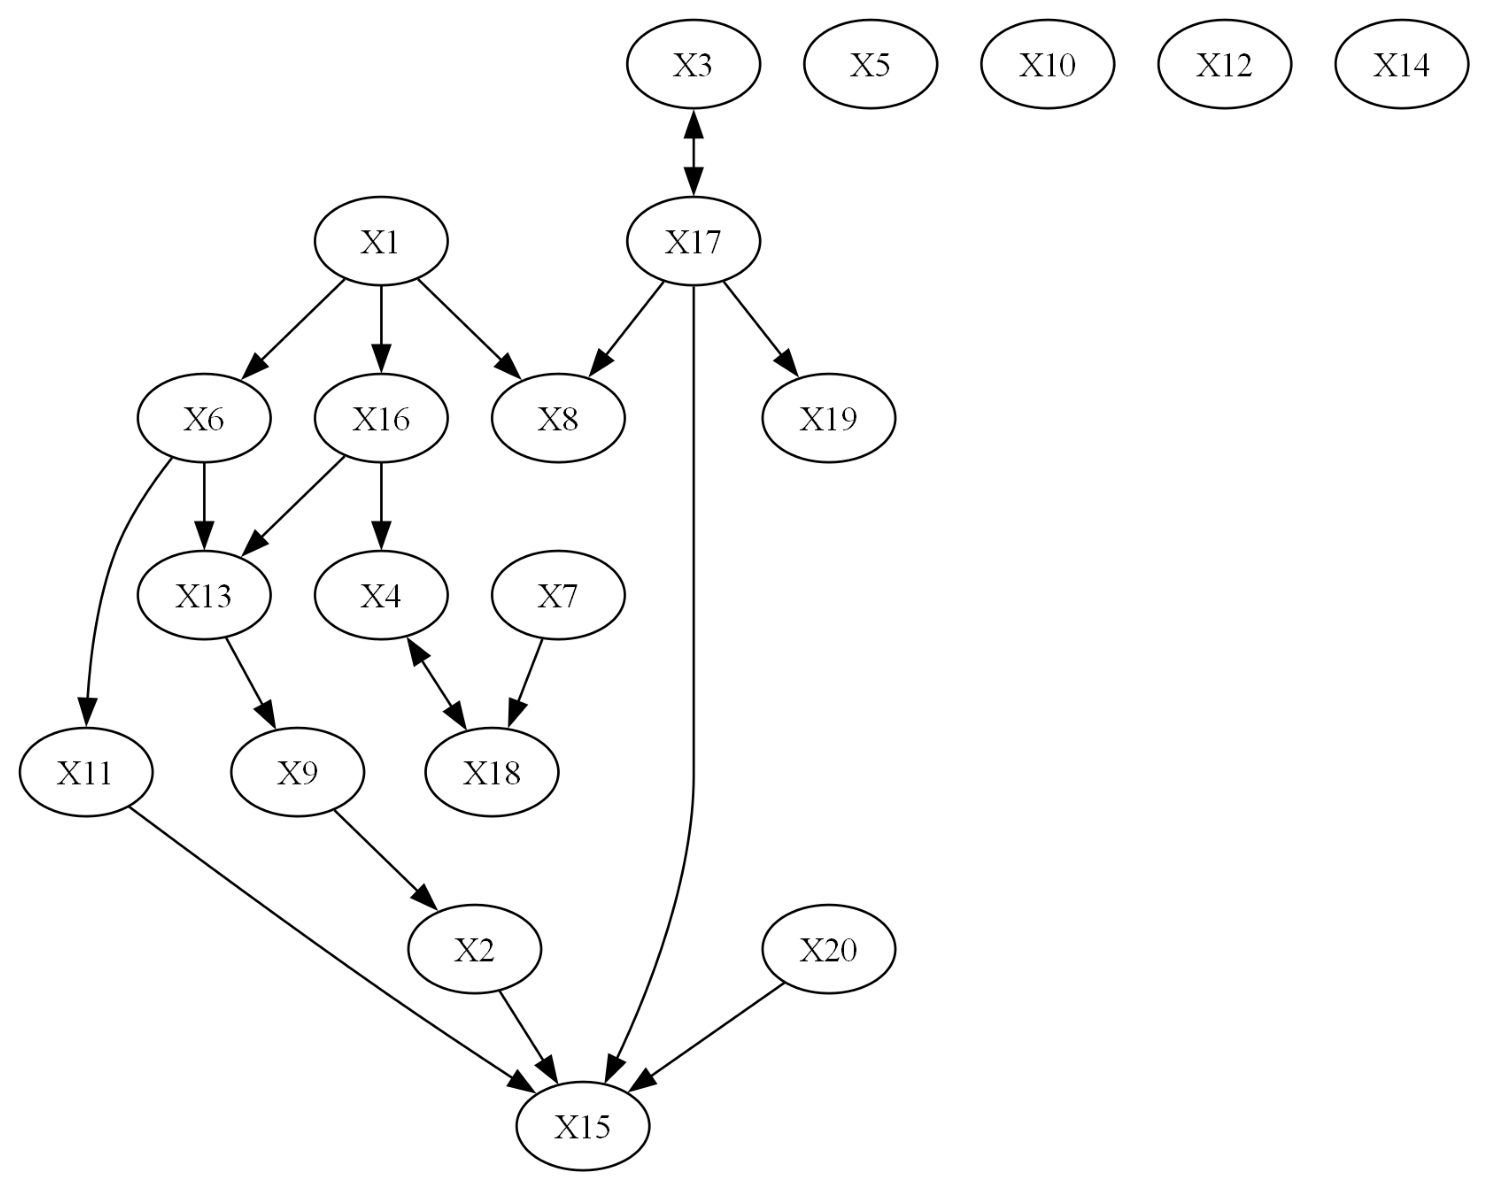

In [5]:
cluster_dag.true_mag.draw_pydot_graph()

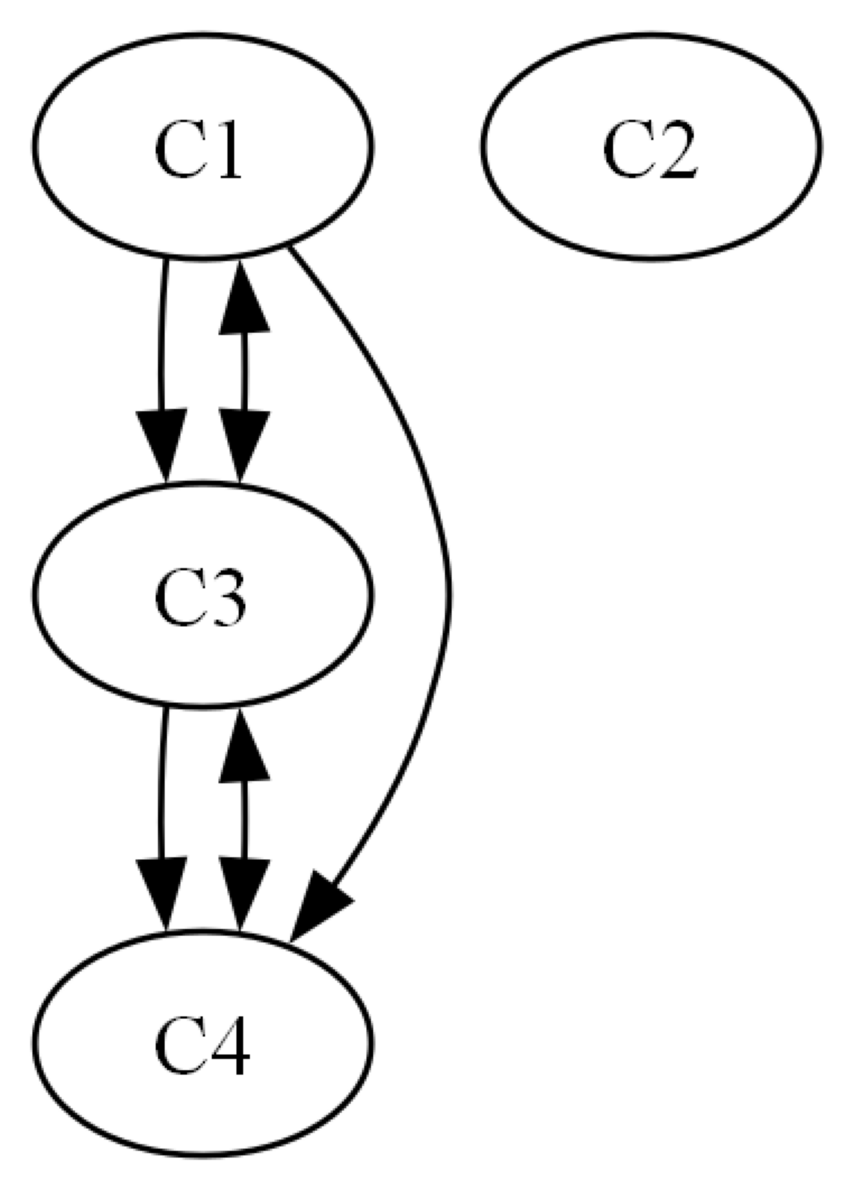

In [6]:
cluster_dag.cluster_graph.draw_pydot_graph()

In [7]:
# cluster_dag.cdag_to_circle_mpdag()
# cluster_dag.cg.draw_pydot_graph()

In [8]:
cluster_dag.cluster_mapping

{'C1': ['X1', 'X7', 'X17', 'X20', 'X3', 'X5', 'X10'],
 'C2': ['X12'],
 'C3': ['X14', 'X6', 'X16', 'X18', 'X8', 'X19', 'X11'],
 'C4': ['X4', 'X13', 'X9', 'X2', 'X15']}

### Evaluate

In [9]:
cluster_fci = ClusterFCI(cluster_dag, dataset = cluster_dag.data, alpha = 0.05)
cluster_cg, cluster_edges = cluster_fci.run()

C4 phase, Depth=4, working on node 14: 100%|██████████| 5/5 [00:00<?, ?it/s, duration: 0.07sec]

X2 --> X9
X11 --> X2
X14 --> X2
X15 --> X4
X11 --> X14
X15 --> X13


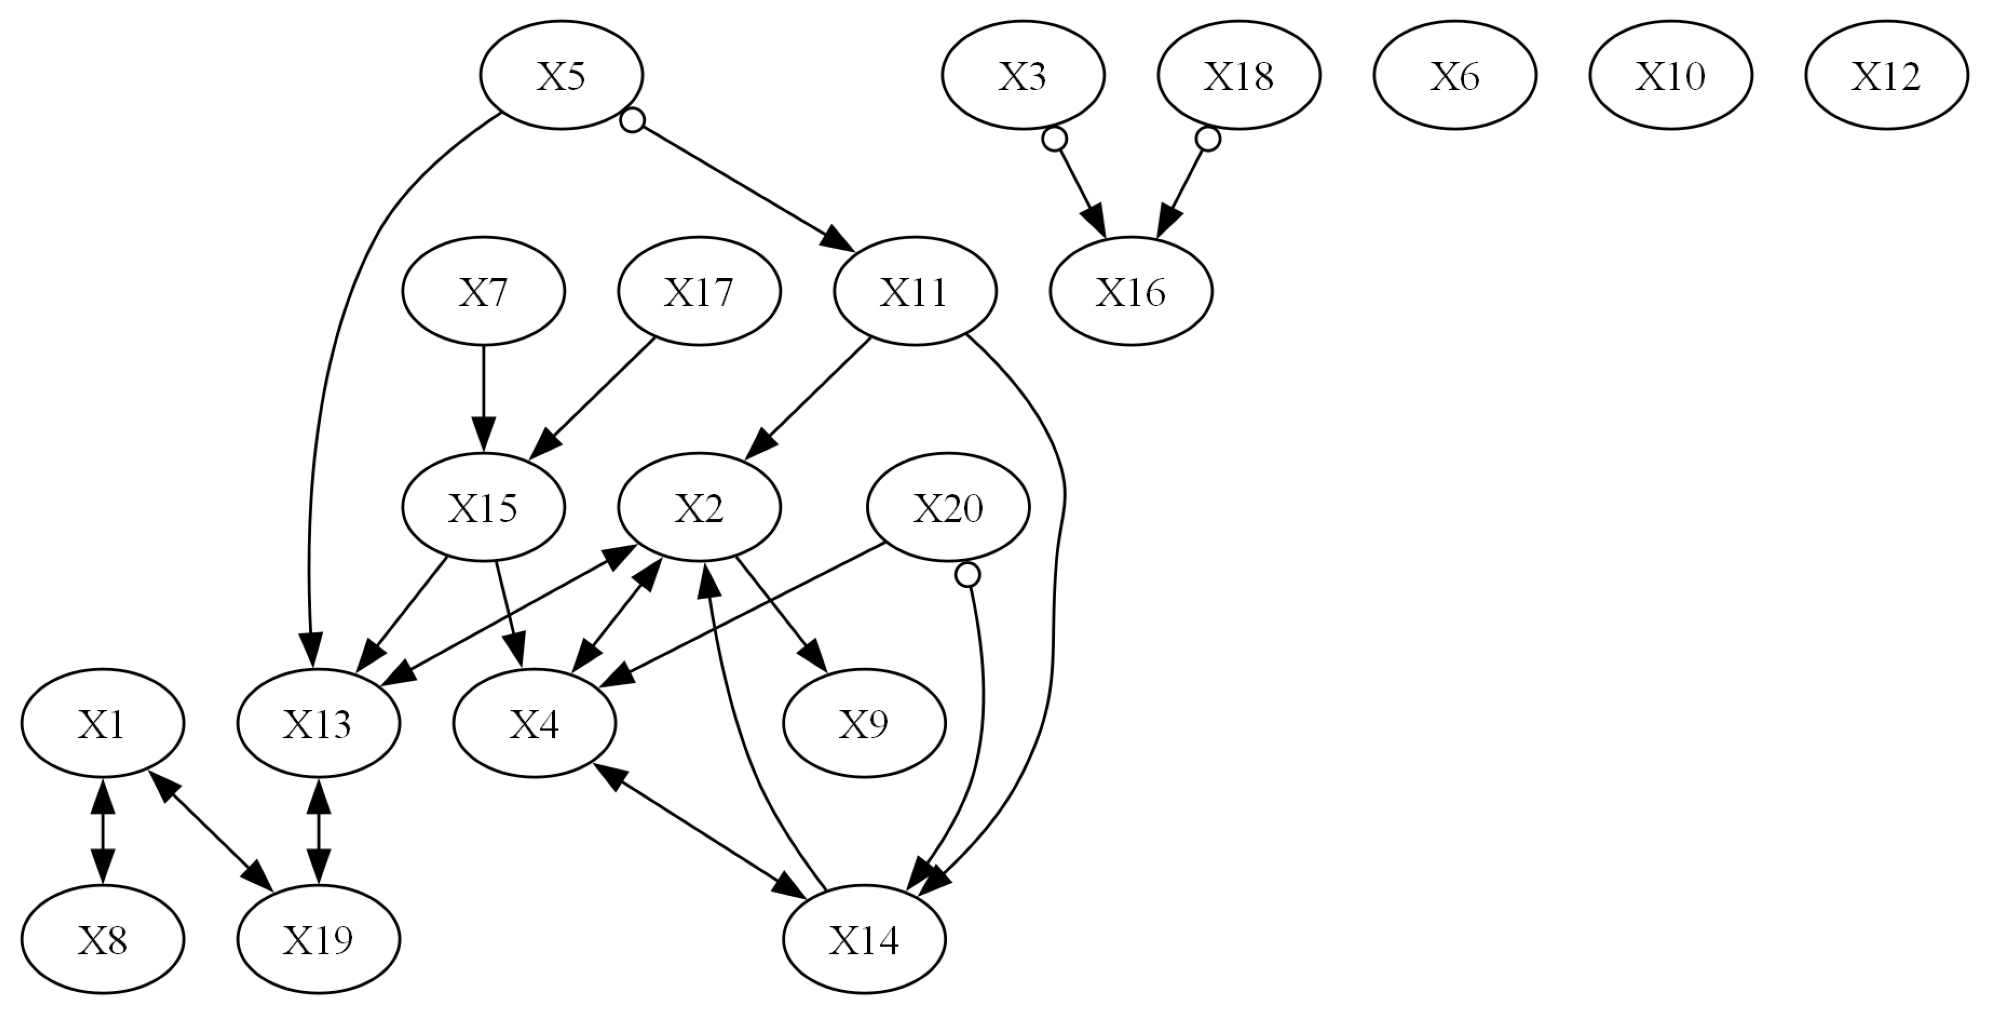

In [10]:
cluster_cg.draw_pydot_graph()

In [11]:
base_G, base_edges = fci(dataset = cluster_dag.data, alpha = 0.05, verbose = False)
base_cg = CausalGraph(len(base_G.get_node_names()))
base_cg.G = base_G

Depth=4, working on node 19: 100%|██████████| 20/20 [00:00<00:00, 1090.44it/s]

X2 --> X9
X14 --> X20


In [12]:
tiers = cluster_dag.get_cluster_topological_ordering()
cluster_mapping = cluster_dag.cluster_mapping
fci_tiers_cg, fci_tiers_edges = fci_tiers(tiers = tiers, \
                                          cluster_mapping = cluster_mapping, \
                                          cdag = cluster_dag, \
                                            dataset = cluster_dag.data, alpha = 0.05, \
                                                verbose = False)

Depth=4, working on node 19: 100%|██████████| 20/20 [00:00<00:00, 1275.81it/s]

X2 --> X9
X11 --> X2
X14 --> X2
X14 --> X4
X15 --> X4
X11 --> X14
X15 --> X13
X19 --> X13


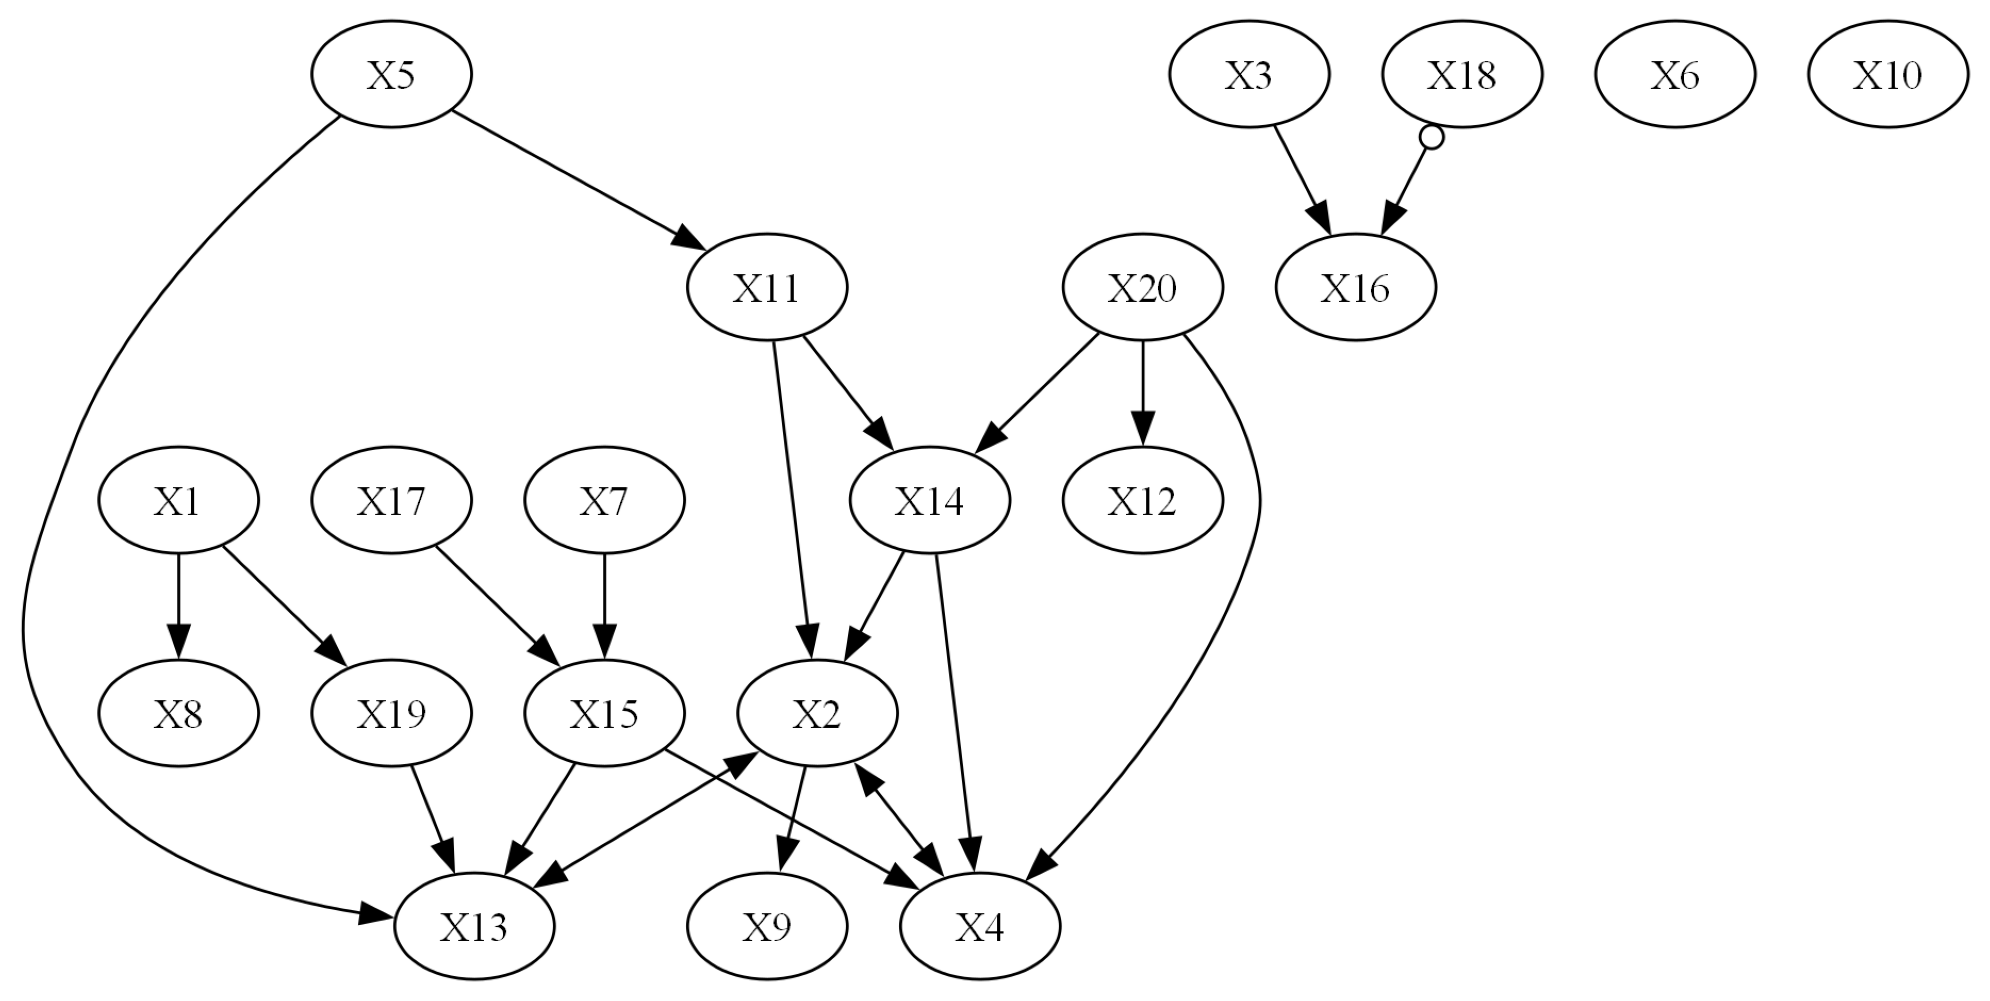

In [13]:
fci_tiers_cg.draw_pydot_graph()

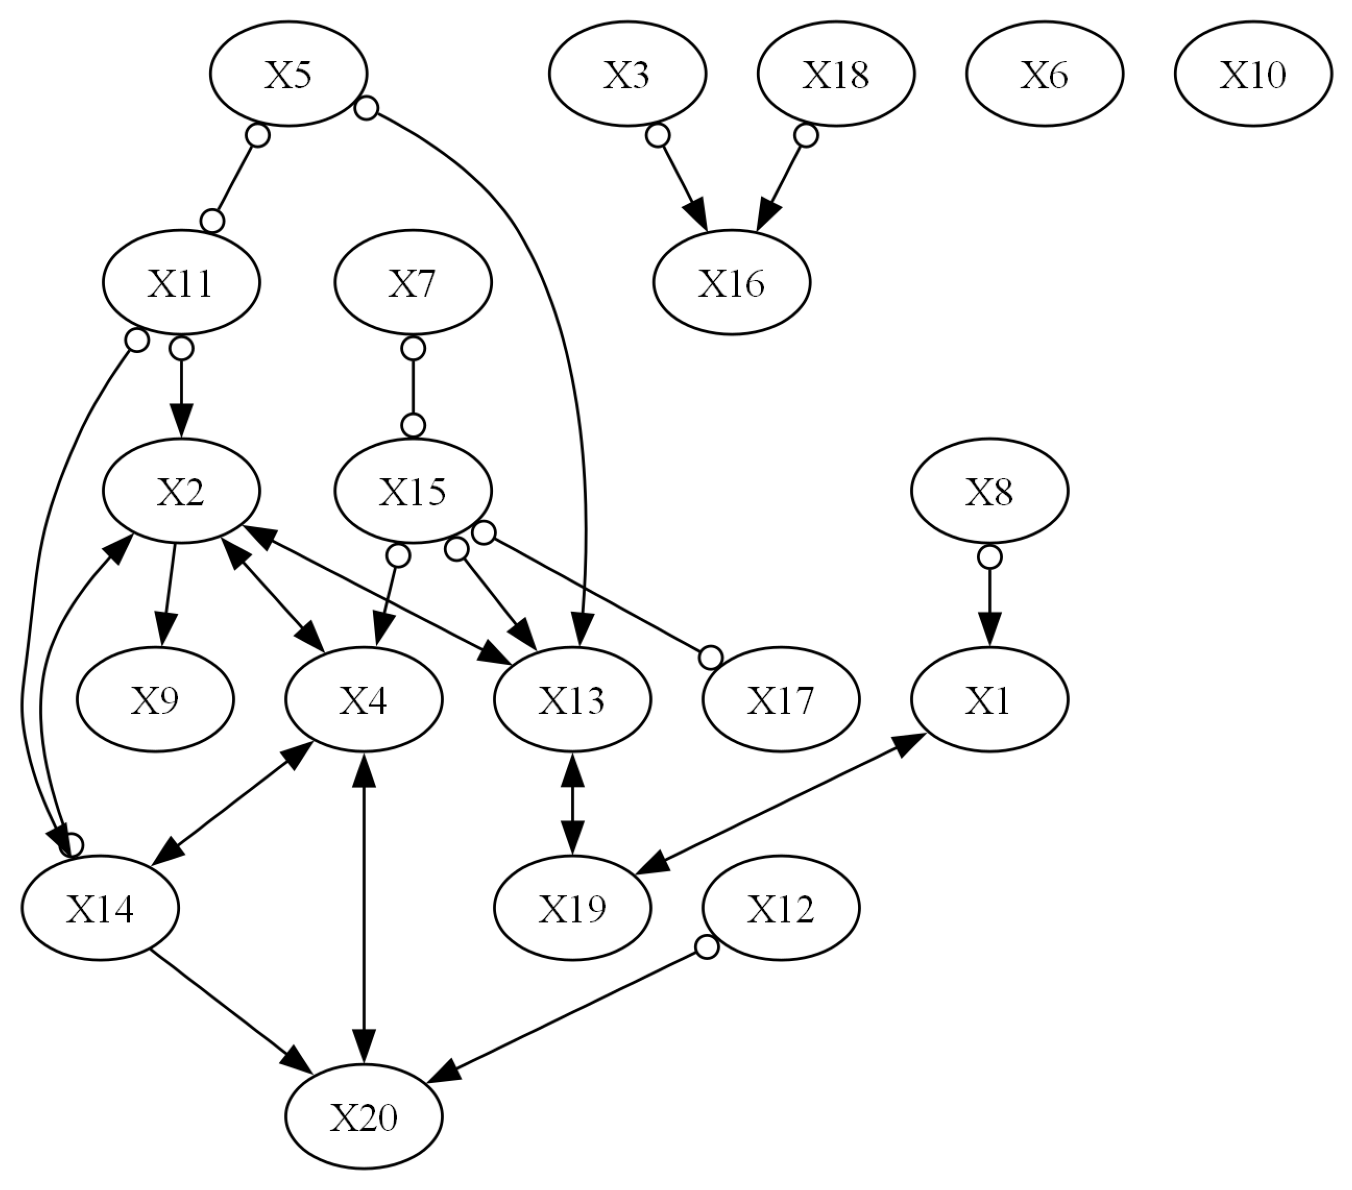

In [14]:
base_cg.draw_pydot_graph()

In [15]:
# Evaluator works on the GeneralGraph object of a CausalGraph object, which is cg.G, cluster_dag.true_dag.G or pc_est_graph.G
eval_fci = Evaluator(truth = cluster_dag.true_mag.G, est = base_cg.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_fci.get_causallearn_metrics(sid = False)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

Adjacency confusion:  {'true_positive': 3, 'false_positive': 18, 'false_negative': 15, 'true_negative': 154, 'precision': 0.14285714285714285, 'recall': 0.16666666666666666, 'f1_score': 0.15384615384615383}
Arrow confusion:  {'true_positive': 0.0, 'false_positive': 24.0, 'false_negative': 20.0, 'true_negative': 356.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'true_positive_ce': 0.0, 'false_positive_ce': 2.0, 'false_negative_ce': 3.0, 'true_negative_ce': 395.0, 'precision_ce': 0.0, 'recall_ce': 0.0, 'f1_score_ce': 0}
SHD:  35
SID:  {'sid_lower': None}


In [16]:
# Evaluator works on the GeneralGraph object of a CausalGraph object, which is cg.G, cluster_dag.true_dag.G or pc_est_graph.G
eval_c_fci = Evaluator(truth = cluster_dag.true_mag.G, est = cluster_cg.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_c_fci.get_causallearn_metrics(sid = False)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

Adjacency confusion:  {'true_positive': 3, 'false_positive': 17, 'false_negative': 15, 'true_negative': 155, 'precision': 0.15, 'recall': 0.16666666666666666, 'f1_score': 0.15789473684210525}
Arrow confusion:  {'true_positive': 2.0, 'false_positive': 24.0, 'false_negative': 18.0, 'true_negative': 356.0, 'precision': 0.07692307692307693, 'recall': 0.1, 'f1_score': 0.08695652173913043, 'true_positive_ce': 2.0, 'false_positive_ce': 2.0, 'false_negative_ce': 1.0, 'true_negative_ce': 395.0, 'precision_ce': 0.5, 'recall_ce': 0.6666666666666666, 'f1_score_ce': 0.5714285714285715}
SHD:  34
SID:  {'sid_lower': None}


In [17]:
# Evaluator works on the GeneralGraph object of a CausalGraph object, which is cg.G, cluster_dag.true_dag.G or pc_est_graph.G
eval_c_fci = Evaluator(truth = cluster_dag.true_mag.G, est = fci_tiers_cg.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_c_fci.get_causallearn_metrics(sid = False)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

Adjacency confusion:  {'true_positive': 3, 'false_positive': 18, 'false_negative': 15, 'true_negative': 154, 'precision': 0.14285714285714285, 'recall': 0.16666666666666666, 'f1_score': 0.15384615384615383}
Arrow confusion:  {'true_positive': 2.0, 'false_positive': 21.0, 'false_negative': 18.0, 'true_negative': 359.0, 'precision': 0.08695652173913043, 'recall': 0.1, 'f1_score': 0.09302325581395349, 'true_positive_ce': 2.0, 'false_positive_ce': 1.0, 'false_negative_ce': 1.0, 'true_negative_ce': 396.0, 'precision_ce': 0.6666666666666666, 'recall_ce': 0.6666666666666666, 'f1_score_ce': 0.6666666666666666}
SHD:  34
SID:  {'sid_lower': None}


### Run gridsearch

In [18]:
# config_path = 'clustercausal\experiments\configs\cluster_vsfcitiers.yaml'
# config_path = config_path.replace('\\', '/')
# experiment = ExperimentRunner(config_path)
# experiment.run_gridsearch_experiment()

In [19]:
data = load_experiment_folder('clustercausal\experiments\_results')

# Load dataframe directly

# To load the dataframe directly, use
# data = pd.read_pickle('clustercausal\experiments\_results_dataframes_for_simulations\data_clusterFCI_simulation.pkl')

In [20]:
# data_all also contains runs with n_clusters = 1
data_all = data.copy()
data_all.to_pickle('clustercausal\experiments\_results_dataframes_for_simulations\data_cluster_vs_fcitiers_final.pkl')
# data = data[data['n_clusters'] != 1]
# # To look only at clusterings where at least two clusters were non-adjacent
# data_nonadj_clusters = data[data['cluster_connectivity'] != 1]

In [21]:
data_all.describe()

,base_adj_f1_score,base_adj_false_negative,base_adj_false_positive,base_adj_precision,base_adj_recall,base_adj_true_negative,base_adj_true_positive,base_arrow_f1_score,base_arrow_f1_score_ce,base_arrow_false_negative,...,alpha,cluster_connectivity,empty_graph_shd,n_clusters,n_edges,n_nodes,noise_scale,sample_size,true_sid_lower,true_sid_upper
count,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,...,1.600000e+02,160.000000,160.000000,160.000000,160.0,160.000000,160.0,160.0,0.0,0.0
mean,0.812780,6.018750,4.693750,0.860988,0.799312,455.093750,22.943750,0.520558,0.647829,16.068750,...,5.000000e-02,0.819375,28.962500,3.500000,30.0,28.750000,1.0,1000.0,NaN,NaN
std,0.089208,4.626247,5.740726,0.132749,0.137275,438.557796,5.175227,0.134123,0.130294,4.669076,...,6.960680e-18,0.228154,5.325727,1.121544,0.0,13.446844,0.0,0.0,NaN,NaN
min,0.535714,0.000000,0.000000,0.433333,0.405405,64.000000,12.000000,0.175439,0.256410,5.000000,...,5.000000e-02,0.166667,13.000000,2.000000,30.0,15.000000,1.0,1000.0,NaN,NaN
25%,0.753074,2.000000,1.000000,0.810764,0.699242,132.500000,19.000000,0.428571,0.548128,13.000000,...,5.000000e-02,0.666667,25.000000,2.750000,30.0,18.750000,1.0,1000.0,NaN,NaN
50%,0.822479,5.000000,2.000000,0.898276,0.827586,280.000000,22.500000,0.512224,0.660920,16.000000,...,5.000000e-02,1.000000,29.000000,3.500000,30.0,25.000000,1.0,1000.0,NaN,NaN
75%,0.881605,9.000000,6.000000,0.955040,0.913949,605.000000,26.250000,0.614921,0.737414,19.000000,...,5.000000e-02,1.000000,32.000000,4.250000,30.0,35.000000,1.0,1000.0,NaN,NaN
max,0.981132,22.000000,26.000000,1.000000,1.000000,1197.000000,37.000000,0.878788,0.935484,30.000000,...,5.000000e-02,1.000000,42.000000,5.000000,30.0,50.000000,1.0,1000.0,NaN,NaN


In [22]:
print(np.sum(data_all['base_adj_f1_score'] == data_all['fcitiers_adj_f1_score']))
print(np.sum(data_all['base_arrow_f1_score'] == data_all['fcitiers_arrow_f1_score']))
print(np.sum(data_all['base_base_shd'] == data_all['fcitiers_fcitiers_shd']))

84
0
24


In [23]:
data_all[data_all['base_arrow_f1_score'] != data_all['fcitiers_arrow_f1_score']][all_metrics].T

NameError: name 'all_metrics' is not defined

In [ ]:
# analyze NA values
data_all.isna().sum()

base_adj_f1_score            0
base_adj_false_negative      0
base_adj_false_positive      0
base_adj_precision           0
base_adj_recall              0
                          ... 
scm_method                   0
seed                       360
true_sid_lower             360
true_sid_upper             360
weight_range                 0
Length: 111, dtype: int64

In [ ]:
print(data_all.columns)

Index(['base_adj_f1_score', 'base_adj_false_negative',
       'base_adj_false_positive', 'base_adj_precision', 'base_adj_recall',
       'base_adj_true_negative', 'base_adj_true_positive',
       'base_arrow_f1_score', 'base_arrow_f1_score_ce',
       'base_arrow_false_negative',
       ...
       'n_clusters', 'n_edges', 'n_nodes', 'noise_scale', 'sample_size',
       'scm_method', 'seed', 'true_sid_lower', 'true_sid_upper',
       'weight_range'],
      dtype='object', length=111)


In [ ]:
# unique values of the columns
configurations = ['n_nodes', 'alpha', 'n_clusters', 'n_edges', 'dag_method', 'distribution_type']
for config in configurations:
    print(f'{config}: {data[config].unique()}')

n_nodes: [18. 15.]
alpha: [0.05]
n_clusters: [2. 3. 4. 5. 6. 7.]
n_edges: [18. 24. 36. 15. 20. 30.]
dag_method: ['erdos_renyi']
distribution_type: ['gauss']


In [ ]:
prec_recall_metrics_with_pruned = ['base_adj_precision', 'pruned_base_adj_precision', 'cluster_adj_precision', \
           'base_adj_recall', 'pruned_base_adj_recall','cluster_adj_recall', \
           'base_adj_f1_score', 'pruned_base_adj_f1_score', 'cluster_adj_f1_score']
prec_recall_metrics = ['base_adj_precision', 'cluster_adj_precision', \
              'base_adj_recall', 'cluster_adj_recall', \
                'base_adj_f1_score', 'cluster_adj_f1_score']
data_all[prec_recall_metrics].describe()

,base_adj_precision,cluster_adj_precision,base_adj_recall,cluster_adj_recall,base_adj_f1_score,cluster_adj_f1_score
count,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000
mean,0.682826,0.662522,0.505631,0.545330,0.568782,0.588899
std,0.310891,0.301424,0.313322,0.316585,0.313475,0.308416
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.387821,0.384615,0.191850,0.221014,0.260168,0.277778
50%,0.824808,0.769231,0.533333,0.622845,0.648162,0.695652
75%,0.947368,0.933333,0.792105,0.840526,0.857143,0.871795
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
prec_recall_metrics_with_fcitiers = ['base_adj_precision', 'cluster_adj_precision', 'fcitiers_adj_precision',\
              'base_adj_recall', 'cluster_adj_recall', 'fcitiers_adj_recall', \
                'base_adj_f1_score', 'cluster_adj_f1_score', 'fcitiers_adj_f1_score']
data_all[prec_recall_metrics_with_fcitiers].describe()

,base_adj_precision,cluster_adj_precision,fcitiers_adj_precision,base_adj_recall,cluster_adj_recall,fcitiers_adj_recall,base_adj_f1_score,cluster_adj_f1_score,fcitiers_adj_f1_score
count,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000
mean,0.682826,0.662522,0.660871,0.505631,0.545330,0.515605,0.568782,0.588899,0.570301
std,0.310891,0.301424,0.322301,0.313322,0.316585,0.307876,0.313475,0.308416,0.311036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.387821,0.384615,0.356092,0.191850,0.221014,0.205660,0.260168,0.277778,0.268590
50%,0.824808,0.769231,0.818015,0.533333,0.622845,0.548589,0.648162,0.695652,0.666667
75%,0.947368,0.933333,0.944444,0.792105,0.840526,0.800000,0.857143,0.871795,0.858766
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
extended_metrics = prec_recall_metrics_with_fcitiers + ['base_base_shd', 'cluster_cluster_shd', 'fcitiers_fcitiers_shd', 'Base indep tests', 'Cluster indep tests']
data_all[extended_metrics].describe()

,base_adj_precision,cluster_adj_precision,fcitiers_adj_precision,base_adj_recall,cluster_adj_recall,fcitiers_adj_recall,base_adj_f1_score,cluster_adj_f1_score,fcitiers_adj_f1_score,base_base_shd,cluster_cluster_shd,fcitiers_fcitiers_shd,Base indep tests,Cluster indep tests
count,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000
mean,0.682826,0.662522,0.660871,0.505631,0.545330,0.515605,0.568782,0.588899,0.570301,19.877778,19.447222,19.308333,1237.447222,696.272222
std,0.310891,0.301424,0.322301,0.313322,0.316585,0.307876,0.313475,0.308416,0.311036,16.265607,17.254203,15.973409,843.546881,533.936621
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,257.000000,46.000000
25%,0.387821,0.384615,0.356092,0.191850,0.221014,0.205660,0.260168,0.277778,0.268590,7.000000,5.000000,5.000000,562.000000,299.000000
50%,0.824808,0.769231,0.818015,0.533333,0.622845,0.548589,0.648162,0.695652,0.666667,16.000000,15.000000,16.000000,1013.000000,580.000000
75%,0.947368,0.933333,0.944444,0.792105,0.840526,0.800000,0.857143,0.871795,0.858766,29.000000,31.000000,29.000000,1705.250000,881.250000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,83.000000,84.000000,80.000000,4913.000000,2831.000000


In [ ]:
arrow_metrics = ['base_arrow_precision', 'cluster_arrow_precision', 'fcitiers_arrow_precision',\
                'base_arrow_recall', 'cluster_arrow_recall', 'fcitiers_arrow_recall',\
                'base_arrow_f1_score', 'cluster_arrow_f1_score', 'fcitiers_arrow_f1_score']

In [ ]:
data_all[arrow_metrics].describe()

,base_arrow_precision,cluster_arrow_precision,fcitiers_arrow_precision,base_arrow_recall,cluster_arrow_recall,fcitiers_arrow_recall,base_arrow_f1_score,cluster_arrow_f1_score,fcitiers_arrow_f1_score
count,358.000000,360.000000,360.000000,360.000000,360.000000,360.000000,358.000000,360.000000,360.000000
mean,0.527337,0.613126,0.619254,0.288958,0.479328,0.449956,0.364255,0.529393,0.507869
std,0.309344,0.310014,0.315117,0.212461,0.305237,0.309509,0.243558,0.306919,0.312263
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.272727,0.333333,0.333333,0.106673,0.187500,0.144410,0.150000,0.239524,0.202174
50%,0.500000,0.696154,0.693980,0.235714,0.477583,0.432432,0.329932,0.581232,0.549323
75%,0.800000,0.896053,0.909091,0.473684,0.752500,0.750000,0.591503,0.821954,0.800000
max,1.000000,1.000000,1.000000,0.933333,1.000000,1.000000,0.965517,1.000000,1.000000


In [ ]:
base_all_metrics = ['base_adj_precision', 'base_adj_recall', 'base_adj_f1_score', 'base_arrow_precision', 'base_arrow_recall', 'base_arrow_f1_score', 'base_base_shd', 'Base indep tests']
cluster_fci_all_metrics = ['cluster_adj_precision', 'cluster_adj_recall', 'cluster_adj_f1_score', 'cluster_arrow_precision', 'cluster_arrow_recall', 'cluster_arrow_f1_score', 'cluster_cluster_shd', 'Cluster indep tests']
fcitiers_all_metrics = ['fcitiers_adj_precision', 'fcitiers_adj_recall', 'fcitiers_adj_f1_score', 'fcitiers_arrow_precision', 'fcitiers_arrow_recall', 'fcitiers_arrow_f1_score', 'fcitiers_fcitiers_shd', 'FCITiers indep tests']

In [ ]:
all_metrics = extended_metrics + arrow_metrics
# all_metrics = prec_recall_metrics_with_fcitiers + extended_metrics
data_all[all_metrics].mean()


base_adj_precision             0.682826
cluster_adj_precision          0.662522
fcitiers_adj_precision         0.660871
base_adj_recall                0.505631
cluster_adj_recall             0.545330
fcitiers_adj_recall            0.515605
base_adj_f1_score              0.568782
cluster_adj_f1_score           0.588899
fcitiers_adj_f1_score          0.570301
base_base_shd                 19.877778
cluster_cluster_shd           19.447222
fcitiers_fcitiers_shd         19.308333
Base indep tests            1237.447222
Cluster indep tests          696.272222
base_arrow_precision           0.527337
cluster_arrow_precision        0.613126
fcitiers_arrow_precision       0.619254
base_arrow_recall              0.288958
cluster_arrow_recall           0.479328
fcitiers_arrow_recall          0.449956
base_arrow_f1_score            0.364255
cluster_arrow_f1_score         0.529393
fcitiers_arrow_f1_score        0.507869
dtype: float64

In [ ]:
#TODO make some plots like for clusterPC or get the tables

In [ ]:
data_all[arrow_metrics].describe().to_markdown()

'|       |   base_arrow_precision |   cluster_arrow_precision |   fcitiers_arrow_precision |   base_arrow_recall |   cluster_arrow_recall |   fcitiers_arrow_recall |   base_arrow_f1_score |   cluster_arrow_f1_score |   fcitiers_arrow_f1_score |\n|:------|-----------------------:|--------------------------:|---------------------------:|--------------------:|-----------------------:|------------------------:|----------------------:|-------------------------:|--------------------------:|\n| count |             358        |                360        |                 360        |          360        |             360        |              360        |            358        |               360        |                360        |\n| mean  |               0.527337 |                  0.613126 |                   0.619254 |            0.288958 |               0.479328 |                0.449956 |              0.364255 |                 0.529393 |                  0.507869 |\n| std   |          

In [ ]:
print(data_all[arrow_metrics].describe().to_latex())

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &  base\_arrow\_precision &  cluster\_arrow\_precision &  fcitiers\_arrow\_precision &  base\_arrow\_recall &  cluster\_arrow\_recall &  fcitiers\_arrow\_recall &  base\_arrow\_f1\_score &  cluster\_arrow\_f1\_score &  fcitiers\_arrow\_f1\_score \\
\midrule
count &            358.000000 &               360.000000 &                360.000000 &         360.000000 &            360.000000 &             360.000000 &           358.000000 &              360.000000 &               360.000000 \\
mean  &              0.527337 &                 0.613126 &                  0.619254 &           0.288958 &              0.479328 &               0.449956 &             0.364255 &                0.529393 &                 0.507869 \\
std   &              0.309344 &                 0.310014 &                  0.315117 &           0.212461 &              0.305237 &               0.309509 &             0.243558 &                0.306919 &                 0.312263 \\


In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
